In [1]:
import numpy as np
import sys

sys.path.append('../code/')

from mlalgos import Sequential,GAN
from mllib import Utilities,MLUtilities

from time import time
import pickle

import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib as mpl
import matplotlib.colors as pltcol
import gc

ut = Utilities()
ml = MLUtilities()

In [2]:
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['legend.fontsize'] = 14 # 14
mpl.rcParams['legend.labelspacing'] = 0.25
FS = 18
FS2 = 15
FS3 = 13
FSL = 22

mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['xtick.minor.size'] = 3
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['ytick.minor.size'] = 3

#mpl.rcParams.keys()

# Example usage of `GAN` (Generative Adversarial Network)

## Derivative test

#### Function definition

In [3]:
def func(x):
    return np.exp(-0.5*x**2)

def der(x):
    return -x*np.exp(-0.5*x**2)

X = ml.rv(np.linspace(-1.5,2,60))
Y = func(X)
dYdX = der(X)

#### Network setup and training

In [4]:
Train = True
start_time = time()
L = 10
params = {'data_dim':X.shape[0],'L':L,
          'n_layer':[20]*(L-1)+[Y.shape[0]],
          'atypes':['relu']*(L-1)+['lin'],
          'loss_type':'square','file_stem':'gan/ddx_test'}
params_train = {'max_epoch':1000,'lrate':1e-4,'mb_count':6,'val_frac':0.2,'check_after':30}

net = Sequential(params)

if Train:
    net.train(X,Y,params_train)
    net.save()
else:
    net.load()
ut.time_this(start_time)

... setting up 10 layer feed-forward neural network
... ... expecting data dim = 1, target dim = 1
... ... using hidden layers of sizes [20,20,20,20,20,20,20,20,20]
... ... ... and activations [relu,relu,relu,relu,relu,relu,relu,relu,relu]
... ... using last activation layer 'lin'
... ... ... with threshold (None means default): None
... ... using loss function 'square'
... ... not using any regularization
... ... not using any weight decay
... training
[.............       ] 66% done
... ... done
0 min 1.72 seconds



#### Plot

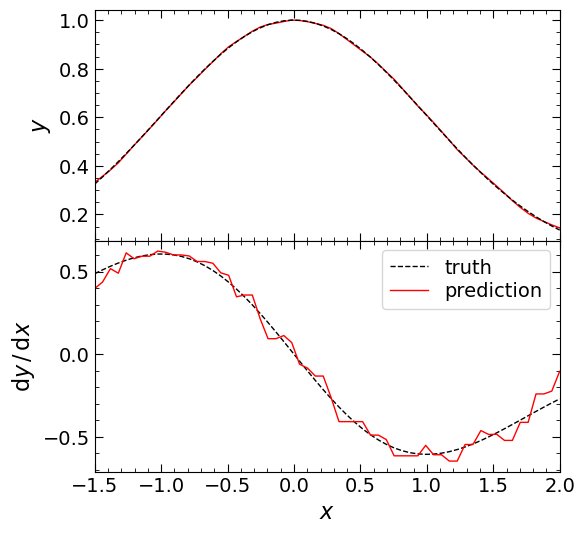

In [7]:
plt.figure(figsize=(6,6))
gs = gridspec.GridSpec(2,1,height_ratios=[1,1],hspace=0)
ax1 = plt.subplot(gs[0])
ax1.set_xlim(X.min(),X.max())
ax1.set_xticklabels('')
ax1.set_ylabel('$y$')
ax1.plot(X[0],net.predict(X)[0],'r-',lw=1,label='prediction')
ax1.plot(X[0],Y[0],'k--',lw=1,label='truth')
ax1.minorticks_on()

ax2 = plt.subplot(gs[1])
ax2.set_xlim(X.min(),X.max())
ax2.set_xlabel('$x$')
ax2.set_ylabel('${\\rm d}y\\,/\\,{\\rm d}x$')
ax2.plot(X[0],dYdX[0],'k--',lw=1,label='truth')
ax2.plot(X[0],net.gradient(X)[0,0],'r-',lw=1,label='prediction')
ax2.legend(loc='upper right')
ax2.minorticks_on()

plt.show()

## GAN Test